In [1]:
#load libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
from pyrestcli.auth import NoAuthClient
from carto.sql import SQLClient
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Greys9, viridis, inferno
from colorcet import fire
from datetime import datetime
import imageio
from datashader.utils import lnglat_to_meters as webm
import matplotlib.pyplot as plt

In [2]:
#initialize the SQL client object
API_endpoint = "https://phl.carto.com"
sql_client = SQLClient(NoAuthClient(API_endpoint))

In [3]:
#load parking violations data
table_name = "parking_violations"
query = "SELECT * FROM %s" %table_name
features = sql_client.send(query, format='geojson')

/Users/sagaridatta/anaconda3/envs/musa-620/lib/python3.6/site-packages/pyrestcli/auth.py:79: UserWarning: You are using methods other than get with no authentication!!!
  warnings.warn(_("You are using methods other than get with no authentication!!!"))


In [4]:
#convert geojson data to geopandas dataframe
parking_violations = gpd.GeoDataFrame.from_features(features, 
                                           crs={'init':'epsg:4326'})

In [5]:
#remove missing geometries
parking_violations = parking_violations.loc[parking_violations.geometry.notnull()]

In [6]:
#check length of dataset
len(parking_violations)

3347781

In [7]:
#check the parking_violations dataframe
parking_violations.head()

,anon_plate_id,anon_ticket_number,cartodb_id,division,fine,geometry,gps,issue_datetime,issuing_agency,lat,location,lon,state,violation_desc,zip_code
0,878255,1777797,1,0001,41,POINT (-75.15893699999999 39.956252),False,2013-08-22T12:36:00Z,PPA,39.956252,212 N 12TH ST,-75.158937,PA,EXPIRED INSPECTION,19107
1,878255,1777798,2,0001,36,POINT (-75.15473 39.955233),False,2013-09-23T21:52:00Z,PPA,39.955233,900 RACE ST,-75.154730,PA,METER EXPIRED CC,19107
2,328900,1777799,3,0001,26,POINT (-75.172386 40.034175),False,2013-11-23T12:25:00Z,PPA,40.034175,5448 GERMANTOWN AVE,-75.172386,NJ,METER EXPIRED,19144
4,665834,1777801,5,0001,36,POINT (-75.157291 39.952661),False,2013-05-17T12:11:00Z,PPA,39.952661,1000 FILBERT ST,-75.157291,PA,METER EXPIRED CC,19107
5,847624,1777802,6,,36,POINT (-75.162902 39.959713),False,2013-10-15T12:10:00Z,PPA,39.959713,1400 CALLOWHILL ST,-75.162902,PA,METER EXPIRED CC,19130


In [8]:
#transform to web mercator crs
parking_violations['x'], parking_violations['y'] = webm(parking_violations['lon'], parking_violations['lat'])

In [9]:
#load city limits data
city_limits = gpd.read_file("City_Limits.geojson").to_crs(epsg=3857)

In [10]:
#function to generate datashaded image
def create_image(df, x_range, y_range, w=900, h=900, cmap=inferno):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot parking violation positions, summing amount of fines
    agg = cvs.points(df, 'x', 'y', ds.sum('fine'))
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [11]:
#convert to datetime object
parking_violations['issue_datetime'] = pd.to_datetime(parking_violations['issue_datetime'])
#add hour column
parking_violations['hour'] = parking_violations['issue_datetime'].dt.hour

In [12]:
#function to generate hour in am/pm format
def convert_to_12hour(hr24):  
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [13]:
def plot_parking_violations(fig, df, hour):
    # trim to the specific hour
    df = df.loc[df['hour']==hour]
    
    #get extents from the 'city_limits' dataframe
    extent = city_limits.total_bounds
    x_range = extent[0], extent[2]
    y_range = extent[1], extent[3]
    
    # create the datashaded image
    img = create_image(df, x_range, y_range)
    
    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[*x_range, *y_range])
    ax.axis('off')
    
    # add city limits boundary i.e., Philadelphia boundary
    city_limits.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
    
    #add text label for hour
    ax.text(0.05, 0.9, convert_to_12hour(hour), color='grey', 
            fontsize=40, ha='left', transform=ax.transAxes)

    
    #add plot title
    fig.text(0.72, 0.2, 'Parking Violations', fontsize=25, color='grey', ha='center')
    fig.text(0.72, 0.25, 'Philadelphia', fontsize=25, color='grey', ha='center')
    
    # format axes
    ax.set_axis_off()
    ax.set_aspect('equal')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()
    
    #draw the figure and return the image
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

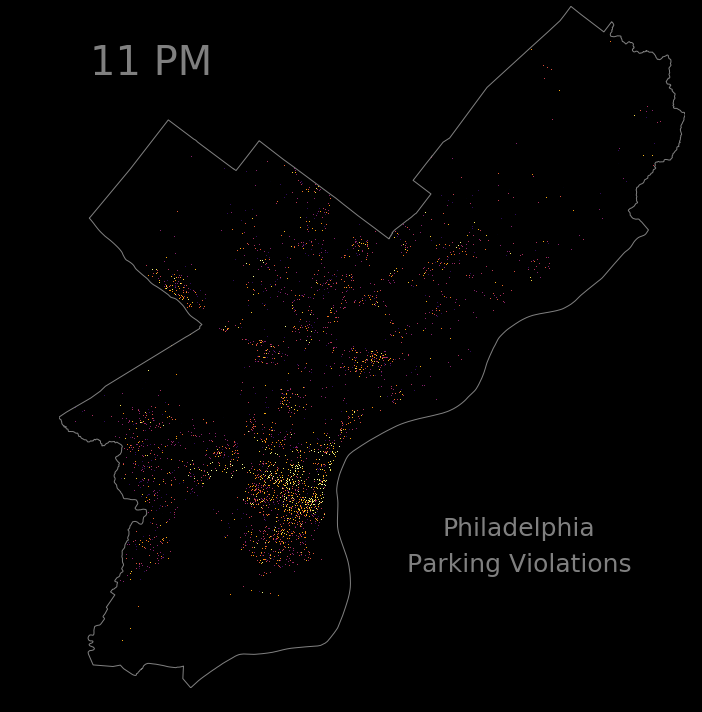

In [14]:
#create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# make images for each hour
hours = list(range(24))
images = []
for hour in hours:
    image = plot_parking_violations(fig, parking_violations, hour)
    images.append(image)
    
    
# combine the images into a GIF
imageio.mimsave('parkingViolations.gif', images, fps=1);